# Analyze data split using  70-30 Balancing score, Jensen-Shannon distance, Overlapping score

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Get the merged malware data
df = pd.read_csv("vt_reports/merge.csv")
df.head()

,sha256,first_submission_date,family
0,98f8e26e12b978102fa39c197f300ebe5fe535617737d5...,1630575593,tnega
1,7b2999ffadbc3b5b5c5e94145ca4e2f8de66ac1e3ddd52...,1629375559,quasar
2,e7569d494fe00be04ef6c9fcc5e54720c0df623b08e79d...,1362057319,pasta
3,1ed60c04f572b6acb9f64c31db55ef5c6b5465bd4da1eb...,1630624233,cjishu
4,4c4aaff20a57213d9a786e56ad22f1eaa94694a2f1042b...,1592186154,kingsoft


In [3]:
fsd = "first_submission_date"

In [4]:
# Convert the timestamps to datetime format
df_dt = df.copy()
df_dt[fsd] = df_dt[fsd].apply(lambda t: pd.to_datetime(t, unit='s'))

In [62]:
def split_and_group_nonzero(src_df: pd.DataFrame, split_condition: bool,
                            split_label: str = ""):
    """
    1. Split the source dataframe by the split_condition
    2. Group by the samples by family by creating a "count" column with the size of each group
    3. Normalize the counts by the total number of samples
    """
    dst_df = src_df.copy()
    dst_df = dst_df[split_condition]
    dst_df = dst_df.groupby(["family"]).size().reset_index(name='count')
    # dst_df["perc"] = dst_df["count"] / dst_df["count"].sum()
    #dst_df["split"] = split_label
    return dst_df


def split_and_group(src_df: pd.DataFrame, split_condition: bool,
                    ref_df: pd.DataFrame, split_label: str = ""):
    """
    Given a source dataset with the following columns: [family, perc, count],
    extend it by adding families of reference dataframe not yet included,
    setting perc and count to zeros.
    """
    df = split_and_group_nonzero(src_df=src_df, split_condition=split_condition, split_label=split_label)
    missed_families = [f for f in ref_df["family"].unique() if f not in list(df["family"])]
    df_missed_families = pd.DataFrame({"family": missed_families, "count": np.zeros(len(missed_families))})
    dst_df = pd.concat([df, df_missed_families]).sort_values(by="family")
    # dst_df["split"] = split_label
    return dst_df

In [173]:
def compute_scores(df: pd.DataFrame, ref_df: pd.DataFrame, date_split: pd.Timestamp):
    """
    Compute the scores: Jensen-Shannon score, Overlapping score, Train-Test balancing
    """
    # JS
    df_train_all = split_and_group(src_df=df, split_condition=df[fsd] < date_split, ref_df=ref_df)
    df_test_all = split_and_group(src_df=df, split_condition=df[fsd] >= date_split, ref_df=ref_df)
    js = jensenshannon(np.array(df_train_all["count"]), np.array(df_test_all["count"]))

    # Train-Test balancing
    train_prop, test_prop = (len(df[df[fsd] < date_split]) / len(ref_df),
                             len(df[df[fsd] >= date_split]) / len(ref_df))
    bs = 1 - np.abs(train_prop - 0.8) / 0.8

    # Overlapping score
    df_train_nonzero = split_and_group_nonzero(src_df=df, split_condition=df[fsd] < date_split)
    df_test_nonzero = split_and_group_nonzero(src_df=df, split_condition=df[fsd] >= date_split)

    os = (len(np.intersect1d(df_train_nonzero["family"].unique(), df_test_nonzero["family"].unique())) /
          len(ref_df["family"].unique()))

    return {"js": js, "bs": bs, "os": os}


In [174]:
# Min and maximum dates
date_min = df_dt[fsd].min()
date_max = df_dt[fsd].max()

date_min_n = pd.Timestamp(f"{date_min.year}-{date_min.month}-{date_min.day}")
date_max_n = pd.Timestamp(f"{date_max.year}-{date_max.month}-{date_max.day}")

# Create 1-month equidistant splits
date_splits = pd.date_range(start=date_min_n, end=date_max_n, freq="MS").tolist()
date_splits

[Timestamp('2006-06-01 00:00:00'),
 Timestamp('2006-07-01 00:00:00'),
 Timestamp('2006-08-01 00:00:00'),
 Timestamp('2006-09-01 00:00:00'),
 Timestamp('2006-10-01 00:00:00'),
 Timestamp('2006-11-01 00:00:00'),
 Timestamp('2006-12-01 00:00:00'),
 Timestamp('2007-01-01 00:00:00'),
 Timestamp('2007-02-01 00:00:00'),
 Timestamp('2007-03-01 00:00:00'),
 Timestamp('2007-04-01 00:00:00'),
 Timestamp('2007-05-01 00:00:00'),
 Timestamp('2007-06-01 00:00:00'),
 Timestamp('2007-07-01 00:00:00'),
 Timestamp('2007-08-01 00:00:00'),
 Timestamp('2007-09-01 00:00:00'),
 Timestamp('2007-10-01 00:00:00'),
 Timestamp('2007-11-01 00:00:00'),
 Timestamp('2007-12-01 00:00:00'),
 Timestamp('2008-01-01 00:00:00'),
 Timestamp('2008-02-01 00:00:00'),
 Timestamp('2008-03-01 00:00:00'),
 Timestamp('2008-04-01 00:00:00'),
 Timestamp('2008-05-01 00:00:00'),
 Timestamp('2008-06-01 00:00:00'),
 Timestamp('2008-07-01 00:00:00'),
 Timestamp('2008-08-01 00:00:00'),
 Timestamp('2008-09-01 00:00:00'),
 Timestamp('2008-10-

In [175]:
from scipy.spatial.distance import jensenshannon

df_scores, df_ref_scores = df_dt.copy(), df_dt.copy()
js_scores, overlapping_scores, balance_scores = [], [], []
for date_split in date_splits:
    scores = compute_scores(df=df_scores, ref_df=df_ref_scores, date_split=date_split)
    js_scores.append(scores["js"])
    overlapping_scores.append(scores["os"])
    balance_scores.append(scores["bs"])


In [176]:
def print_statistics(df: pd.DataFrame, split: pd.Timestamp, label: str = ""):
    df_train, df_test = df[df[fsd] < split], df[df[fsd] >= split]
    print("------------------------------------------------------------------")
    print(f"Report: {label}")
    print(f"\tTraining set length: {len(df_train)}, ({len(df_train) / len(df)}%)")
    print(f"\tTesting set length: {len(df_test)}, ({len(df_test) / len(df)}%)")
    print(f"\tNum families in training: {len(df_train['family'].unique())}")
    print(f"\tNum families in testing: {len(df_test['family'].unique())}")

    n_cup = len(np.intersect1d(df_train['family'].unique(), df_test['family'].unique()))
    print(f"\tCommon families: {n_cup} (OS: {n_cup / len(df['family'].unique())})")
    print(f"\tFamilies in training but not in testing: {len(df_train['family'].unique()) - n_cup}")
    print(f"\tFamilies in testing but not in training: {len(df_test['family'].unique()) - n_cup}")
    print("------------------------------------------------------------------")

# 1. Plot the 70-30 Balancing score between train and test set

As shown below, the highest balancing score is achieved using 2021-12-01 as the timestamp split.
However, the overlapping score is very high (~0.9), so we further investigate the data on the latest years where there's both an increase and peak of $BS$ to see if we can choose a point where it's smaller.

Max balance score 0.8575
------------------------------------------------------------------
Report: Best split based on Balance score at: 2021-12-01 00:00:00
	Training set length: 45962, (0.686%)
	Testing set length: 21038, (0.314%)
	Num families in training: 661
	Num families in testing: 611
	Common families: 602 (OS: 0.8985074626865671)
	Families in training but not in testing: 59
	Families in testing but not in training: 9
------------------------------------------------------------------


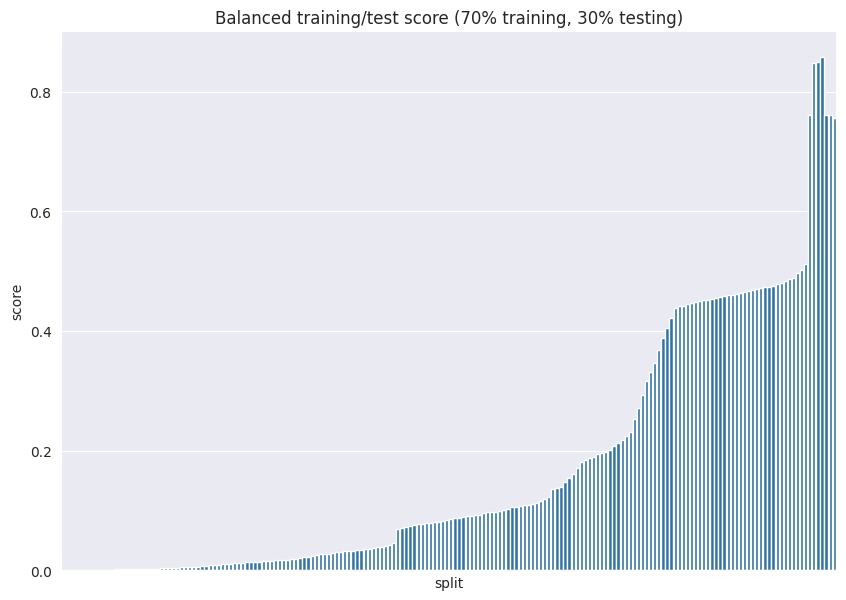

In [177]:
max_bs, idx_max_bs = np.max(balance_scores), np.argmax(balance_scores)

max_bs_split = date_splits[idx_max_bs]
print(f"Max balance score {max_bs}")
print_statistics(df_scores, max_bs_split, f"Best split based on Balance score at: {max_bs_split}")

#normalized_bs = [nd / np.max(balance_scores) for nd in balance_scores]

df_bs = pd.DataFrame({"split": date_splits, "score": balance_scores})
plt.figure(figsize=(10, 7))
ax = sns.barplot(data=df_bs, x="split", y="score")
#ax.patches[idx_max_bs].set_facecolor('red')

plt.title("Balanced training/test score (70% training, 30% testing)")
plt.xticks([])
plt.show()

# 2. Score focus

From later on, the analysis will focus on the latest years, where there's both an increase and peak of $BS$.
Splits at and after 2018-12-01 are considered, where the $BS > 0.4$.

## Observations

- In the last three splits (from 2022-01-01) the overlapping score is very low because lots of families disappear, but any new one appears: even if it is low, those splits are not interesting to study family drift.
- From 2021-10-01 to 2021-12-01 (included) there's not a significant change in overlapping score, it's quite stable at ~0.9. In all the tree splits 9 families are introduced in the test set.
- At 2021-09-01 there's an higher overlapping score compared to the subsequent three (described in the previous point), but 16 families are introduced in the test set as opposed to 9.
- The bins from 2018-10-01 to 2021-08-01 ($0.4 < BS < 0.52$) have training length in percentage that goes to 32% to 40%
- In 2021-08 lots of samples are submitted: at split 2021-08-01 the training/test length in percentage is ~ 40%/60%, and at 2021-09-01 it's 60%/40% respectively.
    Let's investigate this month further using 1-day equidistant splits.

Samples with BS > 0.4 goes from 2018-10-01 00:00:00 to 2022-03-01 00:00:00


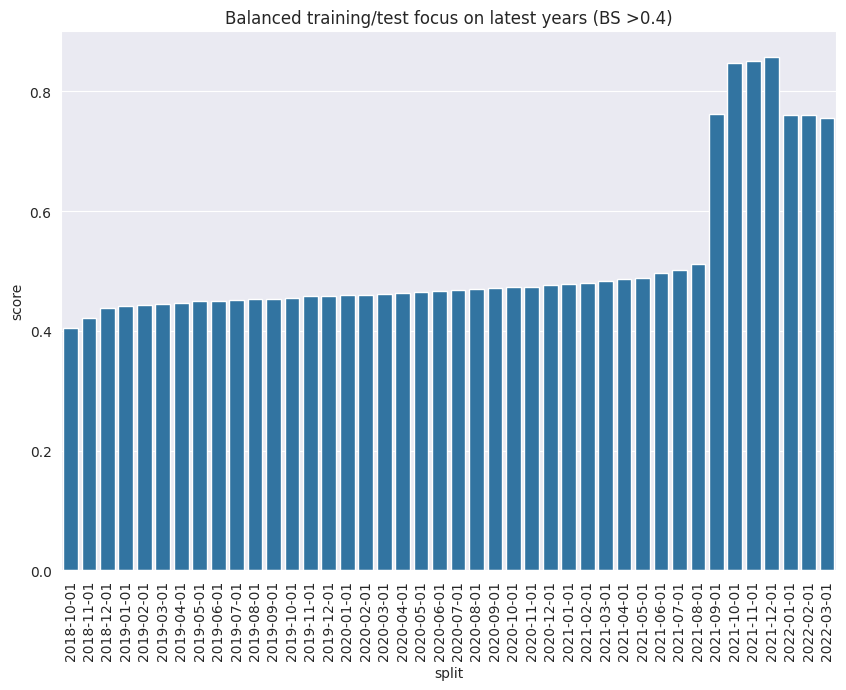

------------------------------------------------------------------
Report: 2018-10-01 00:00:00, BS: 0.4048320895522388
	Training set length: 21699, (0.32386567164179103%)
	Testing set length: 45301, (0.676134328358209%)
	Num families in training: 543
	Num families in testing: 667
	Common families: 540 (OS: 0.8059701492537313)
	Families in training but not in testing: 3
	Families in testing but not in training: 127
------------------------------------------------------------------
------------------------------------------------------------------
Report: 2018-11-01 00:00:00, BS: 0.42235074626865676
	Training set length: 22638, (0.3378805970149254%)
	Testing set length: 44362, (0.6621194029850747%)
	Num families in training: 549
	Num families in testing: 666
	Common families: 545 (OS: 0.8134328358208955)
	Families in training but not in testing: 4
	Families in testing but not in training: 121
------------------------------------------------------------------
-----------------------------

In [186]:
plt.figure(figsize=(10, 7))

df_bs_focus = df_bs[df_bs["score"] > 0.4]
t_focus = df_bs_focus["split"].min()

ax = sns.barplot(data=df_bs_focus, x="split", y="score")
#ax.patches[idx_max_bs].set_facecolor('red')

plt.title(f"Balanced training/test focus on latest years (BS >0.4)")
plt.xticks(rotation=90)
plt.show()

for split in df_bs_focus["split"]:
    print_statistics(df_scores, split, f"{split}, BS: {df_bs_focus[df_bs_focus['split'] == split]['score'].iloc[0]}" )

# 3. Jensen-Shannon distance and Overlapping score: Considerations

As discussed before, in the three bins lots of families disappear and no one appears in the test set.
This explains the drastic increase of Jensen-Shannon distance and drastic decrease of Overlapping score.
However, those three splits are not interesting for studying family drift.

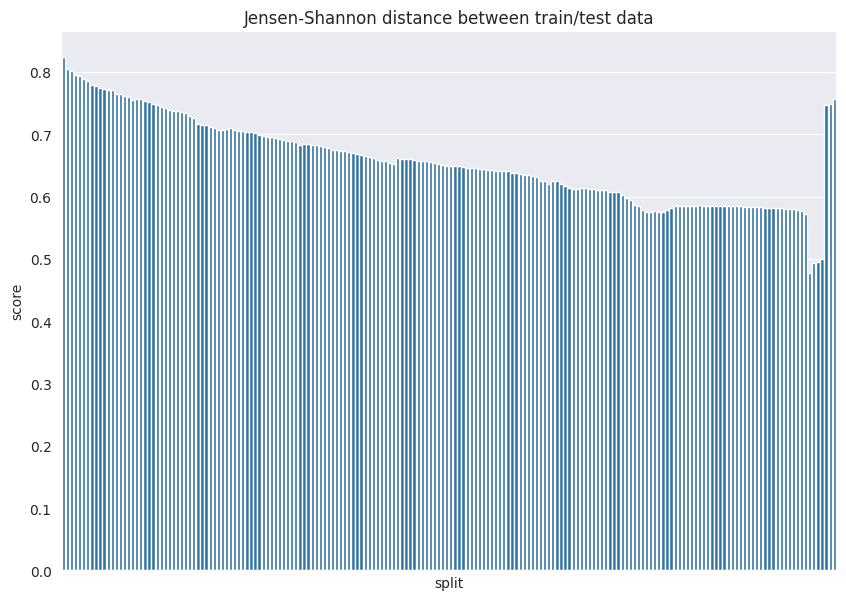

In [183]:
df_js = pd.DataFrame({"split": date_splits, "score": js_scores})
plt.figure(figsize=(10, 7))
ax = sns.barplot(data=df_js, x="split", y="score")
plt.title("Jensen-Shannon distance between train/test data")
plt.xticks([])
plt.show()

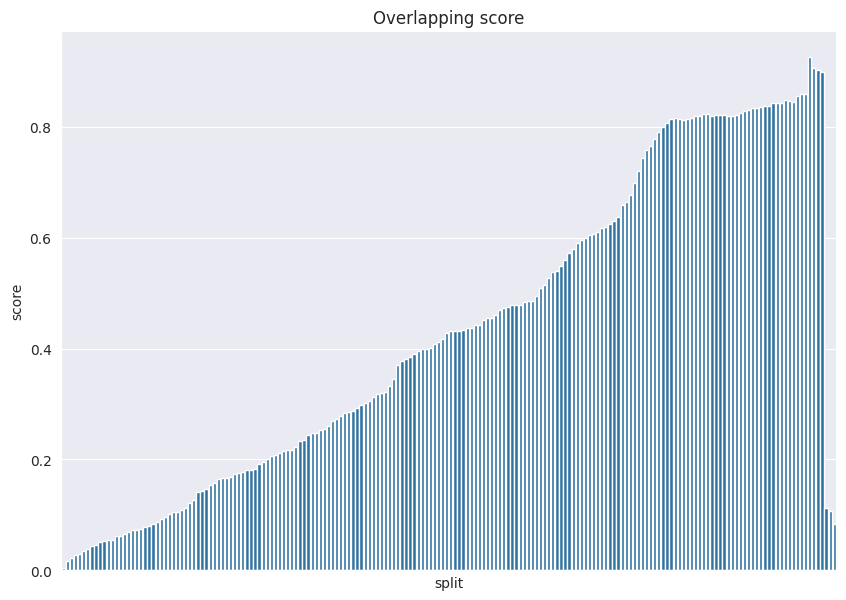

In [118]:
plt.figure(figsize=(10, 7))
df_os = pd.DataFrame({"split": date_splits, "score": overlapping_scores})
ax = sns.barplot(data=df_os, x="split", y="score")
#index_to_color_red = date_splits.index(pd.Timestamp("2021-12-01"))
#ax.patches[index_to_color_red].set_facecolor('red')
plt.title("Overlapping score")
plt.xticks([])
plt.show()

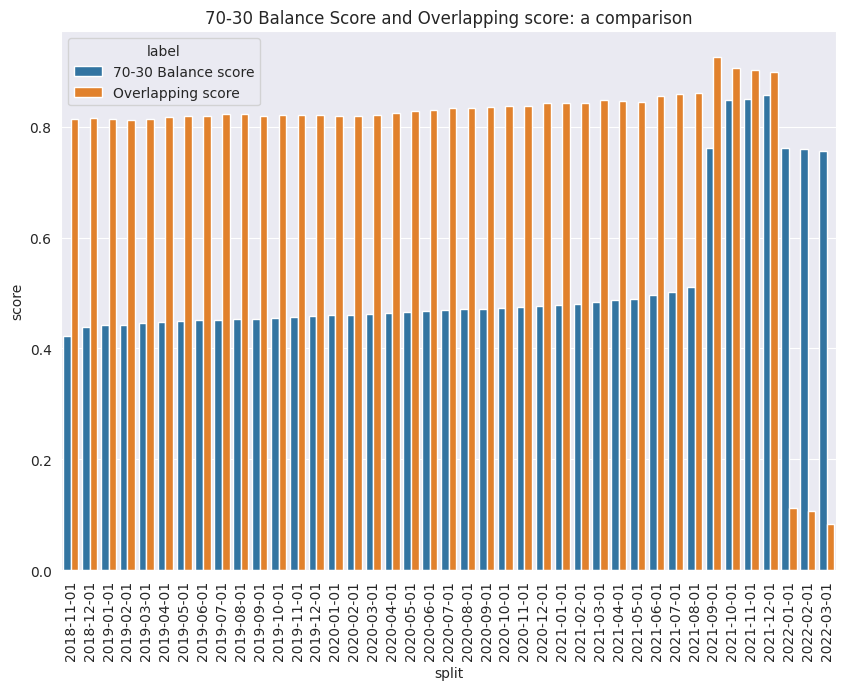

In [189]:
df_bs["label"] = "70-30 Balance score"
df_js["label"] = "Jensen Shannon distance"
df_os["label"] = "Overlapping score"

df_concat_scores = pd.concat([df_bs, df_os])
df_concat_scores = df_concat_scores[df_concat_scores["split"] > t_focus]

plt.figure(figsize=(10, 7))
ax = sns.barplot(data=df_concat_scores, x="split", hue="label", y="score")
plt.title("70-30 Balance Score and Overlapping score: a comparison")
plt.xticks(rotation=90)
plt.show()

# 4. Analyze 2021-08 using 1-day equidistant splits 

In [191]:
date_min, date_max = pd.Timestamp(f"2021-08-01"), pd.Timestamp(f"2021-08-31")

# Create 1-day equidistant splits
date_splits = pd.date_range(start=date_min, end=date_max, freq="D").tolist()
date_splits

[Timestamp('2021-08-01 00:00:00'),
 Timestamp('2021-08-02 00:00:00'),
 Timestamp('2021-08-03 00:00:00'),
 Timestamp('2021-08-04 00:00:00'),
 Timestamp('2021-08-05 00:00:00'),
 Timestamp('2021-08-06 00:00:00'),
 Timestamp('2021-08-07 00:00:00'),
 Timestamp('2021-08-08 00:00:00'),
 Timestamp('2021-08-09 00:00:00'),
 Timestamp('2021-08-10 00:00:00'),
 Timestamp('2021-08-11 00:00:00'),
 Timestamp('2021-08-12 00:00:00'),
 Timestamp('2021-08-13 00:00:00'),
 Timestamp('2021-08-14 00:00:00'),
 Timestamp('2021-08-15 00:00:00'),
 Timestamp('2021-08-16 00:00:00'),
 Timestamp('2021-08-17 00:00:00'),
 Timestamp('2021-08-18 00:00:00'),
 Timestamp('2021-08-19 00:00:00'),
 Timestamp('2021-08-20 00:00:00'),
 Timestamp('2021-08-21 00:00:00'),
 Timestamp('2021-08-22 00:00:00'),
 Timestamp('2021-08-23 00:00:00'),
 Timestamp('2021-08-24 00:00:00'),
 Timestamp('2021-08-25 00:00:00'),
 Timestamp('2021-08-26 00:00:00'),
 Timestamp('2021-08-27 00:00:00'),
 Timestamp('2021-08-28 00:00:00'),
 Timestamp('2021-08-

In [192]:
df_scores, df_ref_scores = df_dt.copy(), df_dt.copy()
js_scores, overlapping_scores, balance_scores = [], [], []
for date_split in date_splits:
    scores = compute_scores(df=df_scores, ref_df=df_ref_scores, date_split=date_split)
    js_scores.append(scores["js"])
    overlapping_scores.append(scores["os"])
    balance_scores.append(scores["bs"])

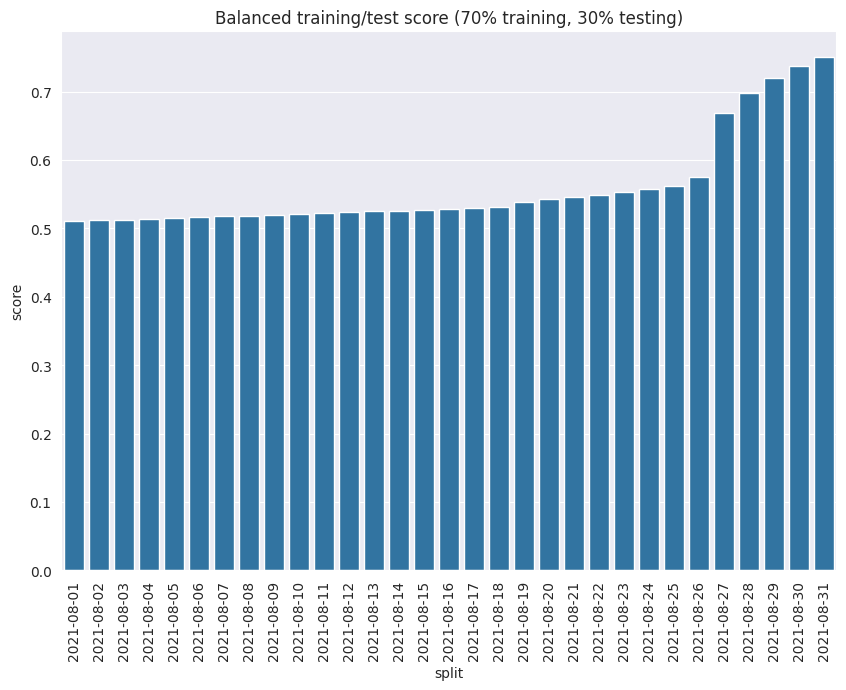

In [196]:
df_bs = pd.DataFrame({"split": date_splits, "score": balance_scores})
plt.figure(figsize=(10, 7))
ax = sns.barplot(data=df_bs, x="split", y="score")
#ax.patches[idx_max_bs].set_facecolor('red')

plt.title("Balanced training/test score (70% training, 30% testing)")
plt.xticks(rotation=90)
plt.show()

In [195]:
for split in df_bs["split"]:
    print_statistics(df_scores, split, f"{split}, BS: {df_bs[df_bs['split'] == split]['score'].iloc[0]}")

------------------------------------------------------------------
Report: 2021-08-01 00:00:00, BS: 0.5114925373134328
	Training set length: 27416, (0.40919402985074627%)
	Testing set length: 39584, (0.5908059701492537%)
	Num families in training: 596
	Num families in testing: 650
	Common families: 576 (OS: 0.8597014925373134)
	Families in training but not in testing: 20
	Families in testing but not in training: 74
------------------------------------------------------------------
------------------------------------------------------------------
Report: 2021-08-02 00:00:00, BS: 0.5119589552238806
	Training set length: 27441, (0.4095671641791045%)
	Testing set length: 39559, (0.5904328358208956%)
	Num families in training: 596
	Num families in testing: 650
	Common families: 576 (OS: 0.8597014925373134)
	Families in training but not in testing: 20
	Families in testing but not in training: 74
------------------------------------------------------------------
-----------------------------